# Acquire the Data

## Acquiring Telco_churn data from SQL Database

In [453]:
import env
import prep
import Models
import pandas as pd
from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler, RobustScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
import numpy as np
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt
import csv
from os import path
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import sklearn.preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
import math
import split_scale
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from graphviz import Source
from scipy import stats

In [2]:
def get_db_url(db):
    return f'mysql+pymysql://{env.user}:{env.password}@{env.host}/{db}'

In [3]:
def get_telco_data_from_mysql():
   
    # Use a double "%" in order to escape %'s default string formatting behavior.
    query = ''' Select * from customers
JOIN contract_types USING (contract_type_id)
Join internet_service_types USING (internet_service_type_id)
JOIN payment_types USING (payment_type_id);

    '''

    url = get_db_url("telco_churn") 
    df = pd.read_sql(query, url)
    return df

In [4]:
df = get_telco_data_from_mysql()

# Look through the data and drop any nulls

## Checking the data for unique values and possible future problems

In [5]:
df.isnull().sum()

payment_type_id             0
internet_service_type_id    0
contract_type_id            0
customer_id                 0
gender                      0
senior_citizen              0
partner                     0
dependents                  0
tenure                      0
phone_service               0
multiple_lines              0
online_security             0
online_backup               0
device_protection           0
tech_support                0
streaming_tv                0
streaming_movies            0
paperless_billing           0
monthly_charges             0
total_charges               0
churn                       0
contract_type               0
internet_service_type       0
payment_type                0
dtype: int64

## It appears that there are no null values in any of the columns, which might make things easier. Let's have a peek at the types of data we're working with.

In [6]:
df.columns

Index(['payment_type_id', 'internet_service_type_id', 'contract_type_id',
       'customer_id', 'gender', 'senior_citizen', 'partner', 'dependents',
       'tenure', 'phone_service', 'multiple_lines', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'paperless_billing', 'monthly_charges',
       'total_charges', 'churn', 'contract_type', 'internet_service_type',
       'payment_type'],
      dtype='object')

In [7]:
# df.head()
# df['online_security']

In [8]:
new_df = df[['customer_id', 'churn', 'contract_type_id', 'contract_type', 'tenure', 'monthly_charges', 'total_charges', 'gender', 'partner', 'dependents', 'senior_citizen', 'phone_service', 'multiple_lines', 'internet_service_type', 'internet_service_type_id' ,'tech_support', 'streaming_tv', 'streaming_movies', 'online_security', 'online_backup', 'device_protection', 'payment_type', 'payment_type_id', 'paperless_billing']]

In [9]:
# new_df.head()

# While there are no nulls that appear, there could be issues with trying to convert the datatypes of some columns

In [10]:
new_df.replace(r'^\s*$', np.nan, regex=True, inplace=True)

In [11]:
df = new_df.dropna()

In [12]:
df.total_charges = df.total_charges.astype(float, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 24 columns):
customer_id                 7032 non-null object
churn                       7032 non-null object
contract_type_id            7032 non-null int64
contract_type               7032 non-null object
tenure                      7032 non-null int64
monthly_charges             7032 non-null float64
total_charges               7032 non-null float64
gender                      7032 non-null object
partner                     7032 non-null object
dependents                  7032 non-null object
senior_citizen              7032 non-null int64
phone_service               7032 non-null object
multiple_lines              7032 non-null object
internet_service_type       7032 non-null object
internet_service_type_id    7032 non-null int64
tech_support                7032 non-null object
streaming_tv                7032 non-null object
streaming_movies            7032 non-null object
online_securi

# It appears that the regex expression has removed a few rows. It has allowed me to change a datatype from an object to a float

## I want to parse down some of these columns to make things a little easier on my cognitive overhead. What I desire is a column with numeric encoders that represent a set of circumstances that can be explained in the data dictionary. First, I want to examine the unique values of these columns to make sure that they either say yes or no. If not, I need to do some replacing. Note that there are several columns that have id types already, which helps.

In [13]:
df.phone_service.unique()

df.tech_support.replace('No internet service', 'No', inplace = True)
df.tech_support.unique()

array(['No', 'Yes'], dtype=object)

In [14]:
## Taking a change in an effort to speed things up. Replacing 'No internet service' across the entire dataframe with 'No'
## Hopefully this is not an Icarus moment for myself

df.replace('No internet service', 'No', inplace = True)



In [15]:
df.multiple_lines.unique()

## My first replace did not convert everything. I need to execute another one.

array(['Yes', 'No', 'No phone service'], dtype=object)

In [16]:
df.replace('No phone service', 'No', inplace=True)

In [17]:
df.multiple_lines.unique()

array(['Yes', 'No'], dtype=object)

In [18]:
# Tired of scrolling up

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 24 columns):
customer_id                 7032 non-null object
churn                       7032 non-null object
contract_type_id            7032 non-null int64
contract_type               7032 non-null object
tenure                      7032 non-null int64
monthly_charges             7032 non-null float64
total_charges               7032 non-null float64
gender                      7032 non-null object
partner                     7032 non-null object
dependents                  7032 non-null object
senior_citizen              7032 non-null int64
phone_service               7032 non-null object
multiple_lines              7032 non-null object
internet_service_type       7032 non-null object
internet_service_type_id    7032 non-null int64
tech_support                7032 non-null object
streaming_tv                7032 non-null object
streaming_movies            7032 non-null object
online_securi

In [19]:
df.contract_type.unique() # Have to leave this with multiple values

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [20]:
df.partner.unique()

array(['No', 'Yes'], dtype=object)

In [21]:
df.dependents.unique()

array(['No', 'Yes'], dtype=object)

In [22]:
df.phone_service.unique()

array(['Yes', 'No'], dtype=object)

In [23]:
df.tech_support.unique()

array(['No', 'Yes'], dtype=object)

In [24]:
df.paperless_billing.unique()

array(['No', 'Yes'], dtype=object)

In [25]:
df.gender.unique()

array(['Male', 'Female'], dtype=object)

In [26]:
df.multiple_lines.unique()

array(['Yes', 'No'], dtype=object)

__It appears that I have my columns where I want them to be with their responses. The next step is to aggregate a few of these columns together by writing code the labels certain circumstances with a number. The first attempt will be with the column for male and female.__

In [27]:
df['e_gender'] = df['gender'].apply({"Male":1,'Female':0}.get)
df.head()

,customer_id,churn,contract_type_id,contract_type,tenure,monthly_charges,total_charges,gender,partner,dependents,...,tech_support,streaming_tv,streaming_movies,online_security,online_backup,device_protection,payment_type,payment_type_id,paperless_billing,e_gender
0,0003-MKNFE,No,1,Month-to-month,9,59.9,542.40,Male,No,No,...,No,No,Yes,No,No,No,Mailed check,2,No,1
1,0013-MHZWF,No,1,Month-to-month,9,69.4,571.45,Female,No,Yes,...,Yes,Yes,Yes,No,No,No,Credit card (automatic),4,Yes,0
2,0015-UOCOJ,No,1,Month-to-month,7,48.2,340.35,Female,No,No,...,No,No,No,Yes,No,No,Electronic check,1,Yes,0
3,0023-HGHWL,Yes,1,Month-to-month,1,25.1,25.10,Male,No,No,...,No,No,No,No,No,No,Electronic check,1,Yes,1
4,0032-PGELS,Yes,1,Month-to-month,1,30.5,30.50,Female,Yes,Yes,...,No,No,No,Yes,No,No,Bank transfer (automatic),3,No,0


In [28]:
# Creating coding references that reduce the number of columns that I have without using the label encoder function from scikit.

#Family describes the family type based on partners and children

conditions_1 =[
    (df['partner']=='Yes')& (df['dependents']=='Yes'),
    (df['partner']=='Yes')& (df['dependents']=='No'),
    (df['partner']=='No')& (df['dependents']=='Yes'),
    (df['partner']=='No')& (df['dependents']=='No')]
choices_1 = [0,1,2,3]
df['family'] = np.select(conditions_1, choices_1)

#Phone services describes whether someone has a phone plan and whether or not they have multiple lines

conditions_2 =[
    (df['phone_service']=='Yes')& (df['multiple_lines']=='Yes'),
    (df['phone_service']=='Yes')& (df['multiple_lines']=='No'),
    (df['phone_service']=='No')& (df['multiple_lines']== 'No')]
choices_2 = [0,1,2]
df['phone_services'] = np.select(conditions_2, choices_2)

#Streaming services denotes what streaming services someone has.

conditions_3 =[
    (df['streaming_tv']=='Yes')& (df['streaming_movies']=='Yes'),
    (df['streaming_tv']=='Yes')& (df['streaming_movies']=='No'),
    (df['streaming_tv']=='No')& (df['streaming_movies']=='Yes'),
    (df['streaming_tv']=='No')& (df['streaming_movies']=='No')]
choices_3 = [0,1,2,3]
df['streaming_services'] = np.select(conditions_3, choices_3)

#Online_services describes what types of online services someone has.

conditions_4=[
    (df['online_security']=='Yes')& (df['online_backup']=='Yes'),
    (df['online_security']=='Yes')& (df['online_backup']=='No'),
    (df['online_security']=='No')& (df['online_backup']=='Yes'),
    (df['online_security']=='No')& (df['online_backup']=='No')]
choices_4 = [0,1,2,3]
df['online_services'] = np.select(conditions_4, choices_4)

#Tech_support as to whether someone has tech support

df['e_tech_support'] = df['tech_support'].apply({"Yes":1,'No':0}.get)

# I'm confident you're getting the sentiment of these

df['e_device_protection'] = df['device_protection'].apply({"Yes":1,'No':0}.get)

# Looking for eco allies with this function

df['e_paperless_billing'] = df['paperless_billing'].apply({"Yes":1,'No':0}.get)

df['e_churn'] = df['churn'].apply({"Yes":1,'No':0}.get)

# df.drop(columns= 'e_senior_citizen', inplace = True)

# I've created a big old dataeframe that has many columns. I want to simplify what I am looking for, so I am going to create a new dataframe comprising all of the encoded columns. I will also create a data dictionary in my README.md so I can keep track of my encoding.

In [30]:
encoded_df = df[['customer_id', 'e_churn','e_gender' ,'contract_type_id', 'contract_type','tenure',
       'monthly_charges', 'total_charges','senior_citizen','internet_service_type_id','family', 'phone_services',
       'streaming_services', 'online_services', 'e_tech_support',
       'e_device_protection', 'e_paperless_billing', 'payment_type_id' ]]

In [31]:
encoded_df.head()

# encoded_df.internet_service_type_id.unique()

,customer_id,e_churn,e_gender,contract_type_id,contract_type,tenure,monthly_charges,total_charges,senior_citizen,internet_service_type_id,family,phone_services,streaming_services,online_services,e_tech_support,e_device_protection,e_paperless_billing,payment_type_id
0,0003-MKNFE,0,1,1,Month-to-month,9,59.9,542.40,0,1,3,0,2,3,0,0,0,2
1,0013-MHZWF,0,0,1,Month-to-month,9,69.4,571.45,0,1,2,1,0,3,1,0,1,4
2,0015-UOCOJ,0,0,1,Month-to-month,7,48.2,340.35,1,1,3,1,3,1,0,0,1,1
3,0023-HGHWL,1,1,1,Month-to-month,1,25.1,25.10,1,1,3,2,3,3,0,0,1,1
4,0032-PGELS,1,0,1,Month-to-month,1,30.5,30.50,0,1,0,2,3,1,0,0,0,3


# Looks a lot cleaner at this stage. Going to create a data dictionary at this point so I can have a quick reference to my encoding.

# Split and Scale

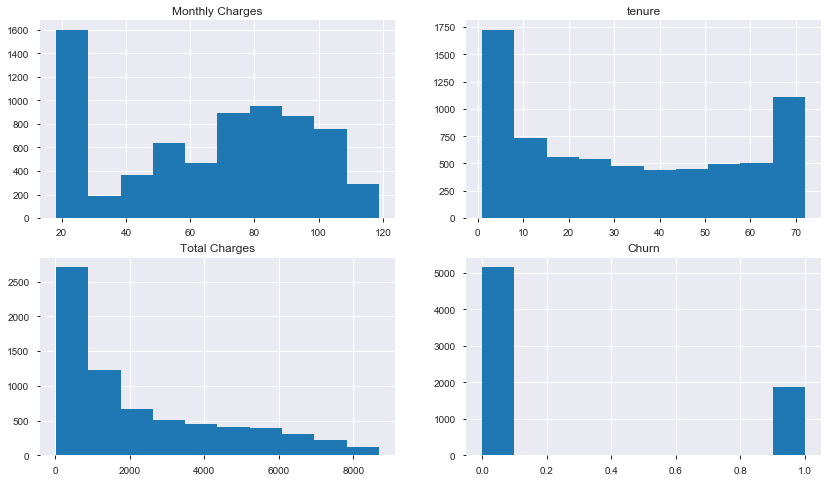

In [32]:
_, ax = plt.subplots(nrows=2, ncols=2, figsize=(14,8))

# plot the first subplot
plt.subplot(221)
plt.hist(encoded_df.monthly_charges)
plt.title('Monthly Charges')

plt.subplot(222)
plt.hist(encoded_df.tenure)
plt.title('tenure')

plt.subplot(223)
plt.hist(encoded_df.total_charges)
plt.title('Total Charges')

plt.subplot(224)
plt.hist(encoded_df.e_churn)
plt.title('Churn')

plt.show()

In [33]:
train, test = train_test_split(encoded_df, test_size=.3, random_state=123, stratify=encoded_df.e_churn)

In [34]:
# train.head()
# test.info()

X_train = train.drop(columns = ['customer_id', 'contract_type', 'e_churn'])
X_test = test.drop(columns = ['customer_id', 'contract_type', 'e_churn'])
y_train = train['e_churn']
y_test = test['e_churn']



# Graphs

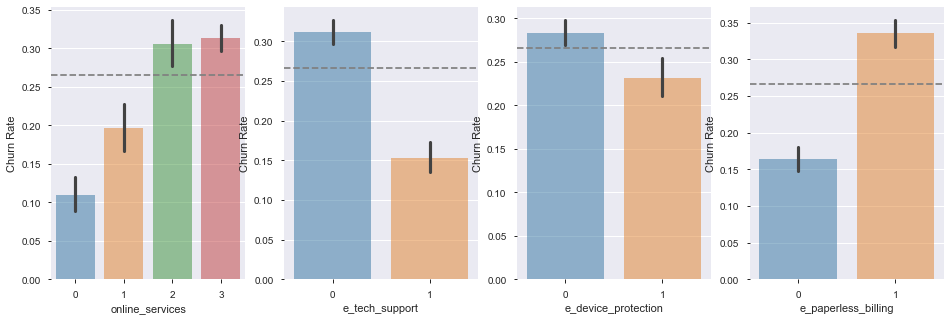

In [35]:
features = ['online_services', 'e_tech_support','e_device_protection', 'e_paperless_billing']

_, ax = plt.subplots(nrows=1, ncols=4, figsize=(16,5))

churn_rate = encoded_df.e_churn.mean()

for i, feature in enumerate(features):
    sns.barplot(feature, 'e_churn', data=train, ax=ax[i], alpha=.5)
    ax[i].set_ylabel('Churn Rate')
    ax[i].axhline(churn_rate, ls='--', color='grey')


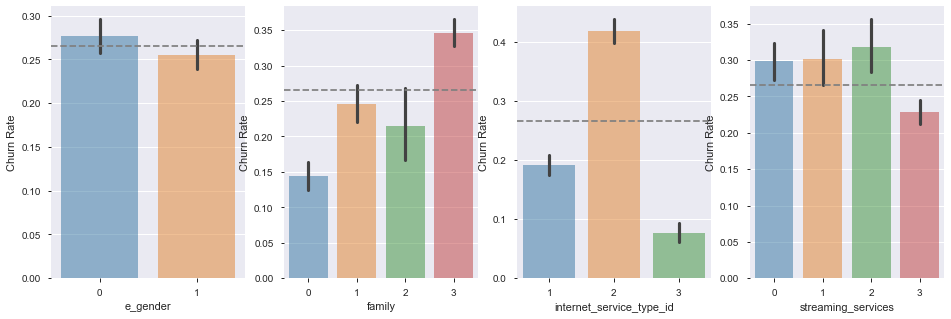

In [36]:
features = ['e_gender', 'family', 'internet_service_type_id', "streaming_services"]

_, ax = plt.subplots(nrows=1, ncols=4, figsize=(16,5))

churn_rate = encoded_df.e_churn.mean()

for i, feature in enumerate(features):
    sns.barplot(feature, 'e_churn', data=train, ax=ax[i], alpha=.5)
    ax[i].set_ylabel('Churn Rate')
    ax[i].axhline(churn_rate, ls='--', color='grey')

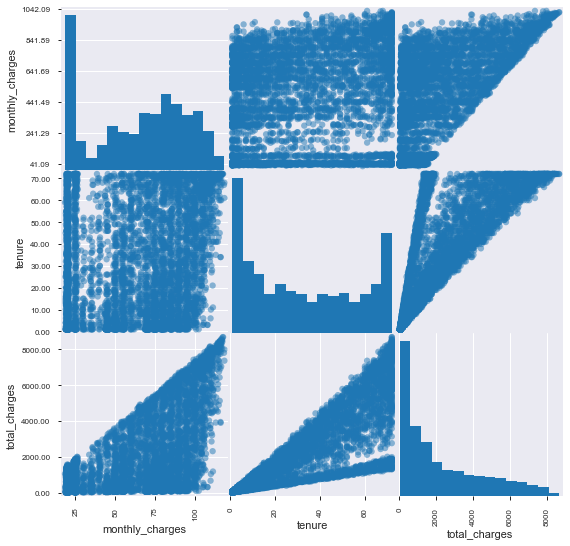

In [37]:
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter

cmap = cm.get_cmap('gnuplot')
axes = pd.plotting.scatter_matrix(
    train[['monthly_charges','tenure','total_charges']], marker='o', s=40,
    hist_kwds={'bins':15},  figsize=(9,9), cmap=cmap)
for ax in axes.flatten():
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))


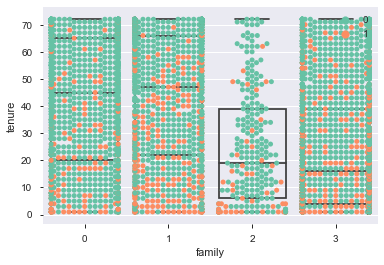

In [38]:
sns.swarmplot(x="family", y="tenure", data=train, hue="e_churn", palette="Set2")
ax = sns.boxplot(x="family", y="tenure", data=train,
        showcaps=True,boxprops={'facecolor':'None'},
        showfliers=True,whiskerprops={'linewidth':0})
plt.legend(loc=1)

In [39]:
pd.crosstab(train.e_gender, train.family, margins=True).style.background_gradient(cmap='YlOrRd')

family,0,1,2,3,All
e_gender,,,,,
0,630,568,96,1155,2449
1,600,575,150,1148,2473
All,1230,1143,246,2303,4922


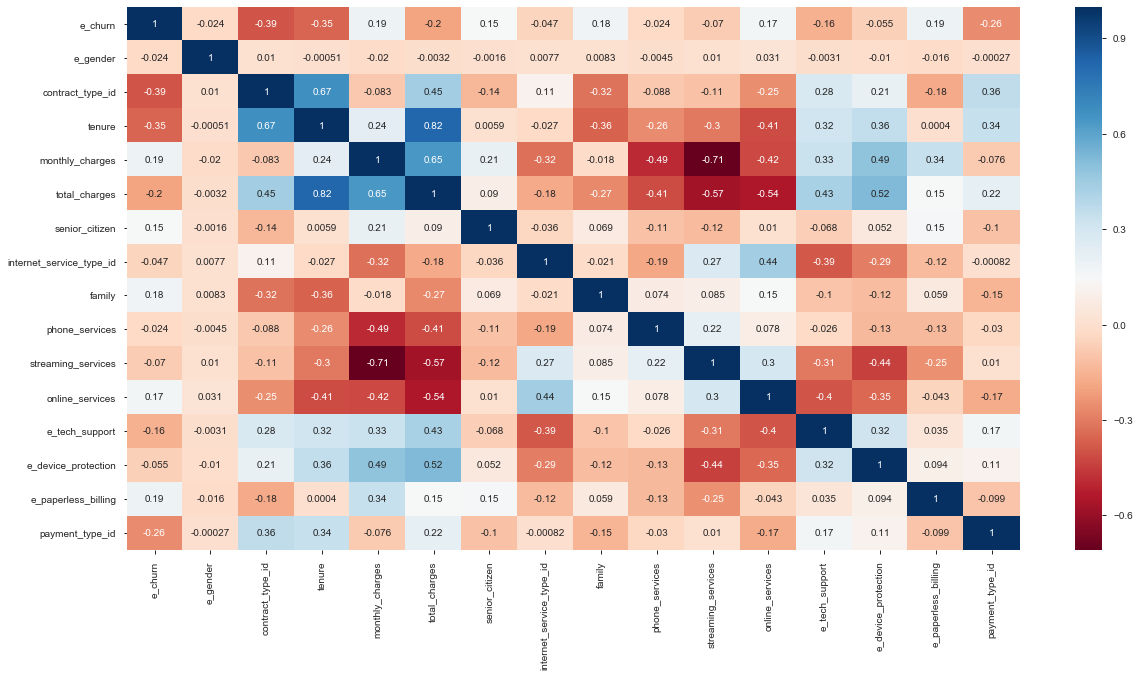

In [40]:
plt.figure(figsize=(20,10))
sns.heatmap(train.corr(), annot = True, cmap ='RdBu')



# Creating a baseline with a decision tree

In [41]:
numeric_X_train = X_train.drop(columns = ['e_gender', 'contract_type_id', 'streaming_services', 'online_services', 'e_tech_support', 'e_device_protection', 'e_paperless_billing','senior_citizen',
       'internet_service_type_id', 'family', 'phone_services', 'payment_type_id'])
numeric_X_test = X_test.drop(columns = ['e_gender', 'contract_type_id', 'streaming_services', 'online_services', 'e_tech_support', 'e_device_protection', 'e_paperless_billing','senior_citizen',
       'internet_service_type_id', 'family', 'phone_services', 'payment_type_id'])
y_train = train['e_churn']
y_test = test['e_churn']



In [377]:
clf = DecisionTreeClassifier(max_depth=2, max_features = 3, random_state=123)
clf.fit(numeric_X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                       max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

In [378]:
y_pred = clf.predict(numeric_X_train)
y_pred
y_pred_proba = clf.predict_proba(numeric_X_train)
y_pred_proba
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(numeric_X_train, y_train)))
confusion_matrix(y_train, y_pred)

Accuracy of Decision Tree classifier on training set: 0.78


array([[3315,  299],
       [ 779,  529]])

In [379]:
y_train.value_counts()

0    3614
1    1308
Name: e_churn, dtype: int64

In [380]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.92      0.86      3614
           1       0.64      0.40      0.50      1308

    accuracy                           0.78      4922
   macro avg       0.72      0.66      0.68      4922
weighted avg       0.76      0.78      0.76      4922



In [381]:
dot_data = export_graphviz(clf, out_file=None) 
graph = Source(dot_data) 

graph.render('telco_decision_tree', view=True)

'telco_decision_tree.pdf'

In [382]:
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(numeric_X_test, y_test)))

Accuracy of Decision Tree classifier on test set: 0.79


## Creating a CSV for the decision tree results

In [384]:
df_final = pd.concat([numeric_X_train, numeric_X_test])
df_final.shape
prediction = clf.predict(df_final)
# y_pred[0:50]
y_pred_proba = clf.predict_proba(df_final)
# y_pred_proba[:,1]
y_predictions = pd.DataFrame({'probability': y_pred_proba[:,1], 'predictions': (y_pred_proba[:,1] >= .5) == 1})
y_predictions = y_predictions.set_index(df.index)
y_predictions.to_csv(r'DT_probability_and_predictions.csv')

# Examining the data with other models

In [387]:
logit = LogisticRegression(C=1, class_weight={1:2}, random_state = 123, solver='saga')
logit.fit(numeric_X_train, y_train)
print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)
y_pred = logit.predict(numeric_X_train)
y_pred_proba = logit.predict_proba(numeric_X_train)
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(numeric_X_train, y_train)))
print(confusion_matrix(y_train, y_pred))

Coefficient: 
 [[-0.02762965  0.01461449 -0.00017413]]
Intercept: 
 [-0.00066583]
Accuracy of Logistic Regression classifier on training set: 0.70
[[2489 1125]
 [ 351  957]]


In [388]:
print(classification_report(y_train, y_pred))
print('Accuracy of Logistic Regression classifier on test set: {:.2f}'
     .format(logit.score(numeric_X_test, y_test)))

              precision    recall  f1-score   support

           0       0.88      0.69      0.77      3614
           1       0.46      0.73      0.56      1308

    accuracy                           0.70      4922
   macro avg       0.67      0.71      0.67      4922
weighted avg       0.77      0.70      0.72      4922

Accuracy of Logistic Regression classifier on test set: 0.70


__It appears that the logistic regression model yields worse results than a decision tree model. Discard.__

# Let's try Random Forest and see what happens

In [448]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=2, 
                            random_state=123)

In [449]:
rf.fit(numeric_X_train, y_train)
print(rf.feature_importances_)
y_pred = rf.predict(numeric_X_train)
y_pred_proba = rf.predict_proba(numeric_X_train)
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(numeric_X_train, y_train)))
print(confusion_matrix(y_train, y_pred))


[0.44784659 0.27422624 0.27792717]
Accuracy of random forest classifier on training set: 0.76
[[3561   53]
 [1118  190]]


In [450]:
print(classification_report(y_train, y_pred))
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf.score(numeric_X_test, y_test)))

              precision    recall  f1-score   support

           0       0.76      0.99      0.86      3614
           1       0.78      0.15      0.25      1308

    accuracy                           0.76      4922
   macro avg       0.77      0.57      0.55      4922
weighted avg       0.77      0.76      0.70      4922

Accuracy of random forest classifier on test set: 0.77


__It appears that the random forest model predicts roughly the same as a decision tree. I will stay with the decision tree for now.__

# K-Nearest Neighbour

In [394]:
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn.fit(numeric_X_train, y_train)
y_pred = knn.predict(numeric_X_train)
y_pred_proba = knn.predict_proba(numeric_X_train)
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(numeric_X_train, y_train)))

Accuracy of KNN classifier on training set: 0.83


In [395]:
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(numeric_X_test, y_test)))

[[3343  271]
 [ 579  729]]
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      3614
           1       0.73      0.56      0.63      1308

    accuracy                           0.83      4922
   macro avg       0.79      0.74      0.76      4922
weighted avg       0.82      0.83      0.82      4922

Accuracy of KNN classifier on test set: 0.77


__After promising test results, the testing of KNN results in an accuracy score of 0.77.__
__Therefore, we shall stick with the Decision Tree model for further exploration.__

# Explore

Q1: Could the month in which they signed up influence churn? i.e. if a cohort is identified by tenure, is there a cohort or cohorts who have a higher rate of churn than other cohorts? (Plot the rate of churn on a line chart where x is the tenure and y is the rate of churn (customers churned/total customers)

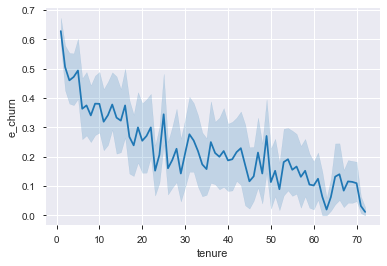

In [47]:
sns.lineplot(x="tenure", y="e_churn", data=train)
plt.show()

__Churn rates appear to be highest in the first months of tenue with an overall decrease in as tenure increases. It is not possible to say whether or not a specific sign-up month influences churn rate and is impossible to determine from the data. While intuitive to think (i.e. Christmas), it is unreasonable to consider given the data at hand.

# Q2: Are there features that indicate a higher propensity to churn? like type of internet service, type of phone service, online security and backup, senior citizens, paying more than x% of customers with the same services, etc.?

# Payment Type Vs Churn Rate

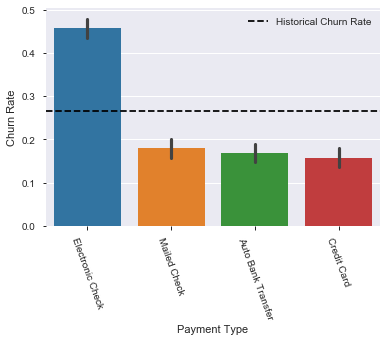

In [398]:
churn_rate = train['e_churn'].mean()

fig = sns.barplot(x="payment_type_id", y="e_churn", data=train)
fig.set_xticklabels(["Electronic Check", "Mailed Check","Auto Bank Transfer", "Credit Card"])
fig.set(ylabel = 'Churn Rate', xlabel= 'Payment Type')
# plt.xlabel('Payment Type') 
plt.axhline(churn_rate, ls='--', label = "Historical Churn Rate", color='black')
plt.legend()
plt.xticks(rotation=-70)
plt.show()

# Family Type Vs Churn Rate

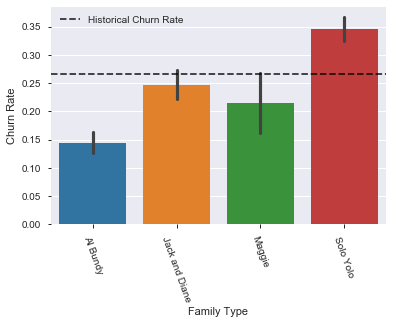

In [400]:
churn_rate = train['e_churn'].mean()

fig = sns.barplot(x="family", y='e_churn', data=train)
fig.set_xticklabels(["Al Bundy", "Jack and Diane","Maggie", "Solo Yolo"])
fig.set(ylabel='Churn Rate', xlabel = 'Family Type')
plt.axhline(churn_rate, ls='--', label = 'Historical Churn Rate', color='black', alpha = 0.8)
plt.xticks(rotation=-70)
plt.legend()
plt.show()

In [65]:
train.columns

Index(['customer_id', 'e_churn', 'e_gender', 'contract_type_id',
       'contract_type', 'tenure', 'monthly_charges', 'total_charges',
       'senior_citizen', 'internet_service_type_id', 'family',
       'phone_services', 'streaming_services', 'online_services',
       'e_tech_support', 'e_device_protection', 'e_paperless_billing',
       'payment_type_id'],
      dtype='object')

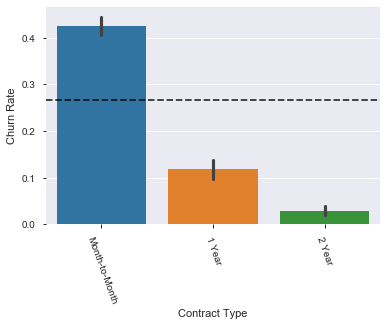

In [401]:
fig = sns.barplot(x="contract_type_id", y='e_churn', data=train)
fig.set_xticklabels(["Month-to-Month", "1 Year","2 Year"])
fig.set(ylabel='Churn Rate', xlabel= 'Contract Type')
plt.axhline(churn_rate, ls='--', label= 'Histroical Churn Rate', alpha = 0.8, color='black')
plt.xticks(rotation=-70)
plt.show()

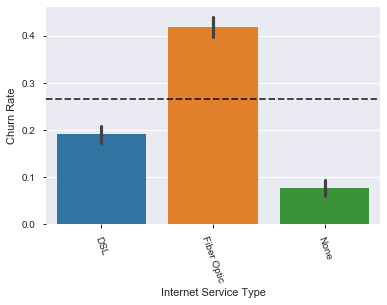

In [402]:
fig = sns.barplot(x="internet_service_type_id", y='e_churn', data=train)
fig.set_xticklabels(["DSL", "Fiber Optic","None"])
fig.set(ylabel='Churn Rate', xlabel= 'Internet Service Type')
plt.axhline(churn_rate, ls='--', label= 'Histroical Churn Rate', alpha = 0.8, color='black')
plt.xticks(rotation=-70)
plt.show()

# Examining churn rates based on contract types

In [170]:
monthtomonth = encoded_df[encoded_df['contract_type_id'] == 1]
oneyear = encoded_df[encoded_df['contract_type_id'] == 2]
twoyear = encoded_df[encoded_df['contract_type_id'] == 3]
priceymtm = monthtomonth[monthtomonth['monthly_charges'] > 50]
midtiermtm = monthtomonth[monthtomonth['monthly_charges'] < 50]
midtiermtm = monthtomonth[monthtomonth['monthly_charges'] >=25]
cheapmtm = monthtomonth[monthtomonth['monthly_charges'] <25]
# monthtomonth
# oneyear
# twoyear

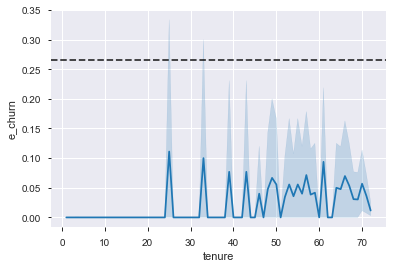

In [403]:
sns.lineplot(x="tenure", y="e_churn", data=twoyear)
plt.axhline(churn_rate, ls='--', label= 'Histroical Churn Rate', alpha = 0.8, color='black')
plt.show()

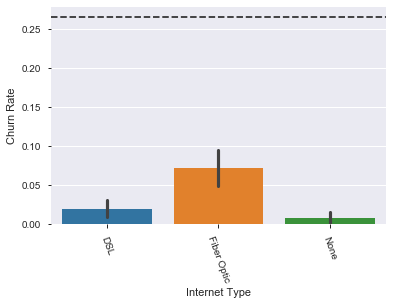

In [433]:
fig = sns.barplot(x="internet_service_type_id", y='e_churn', data=twoyear)
fig.set_xticklabels(["DSL", "Fiber Optic","None"])
fig.set(ylabel='Churn Rate')
fig.set(xlabel='Internet Type')
plt.axhline(churn_rate, ls='--', color='black', alpha =0.8)
plt.xticks(rotation=-70)
plt.show()

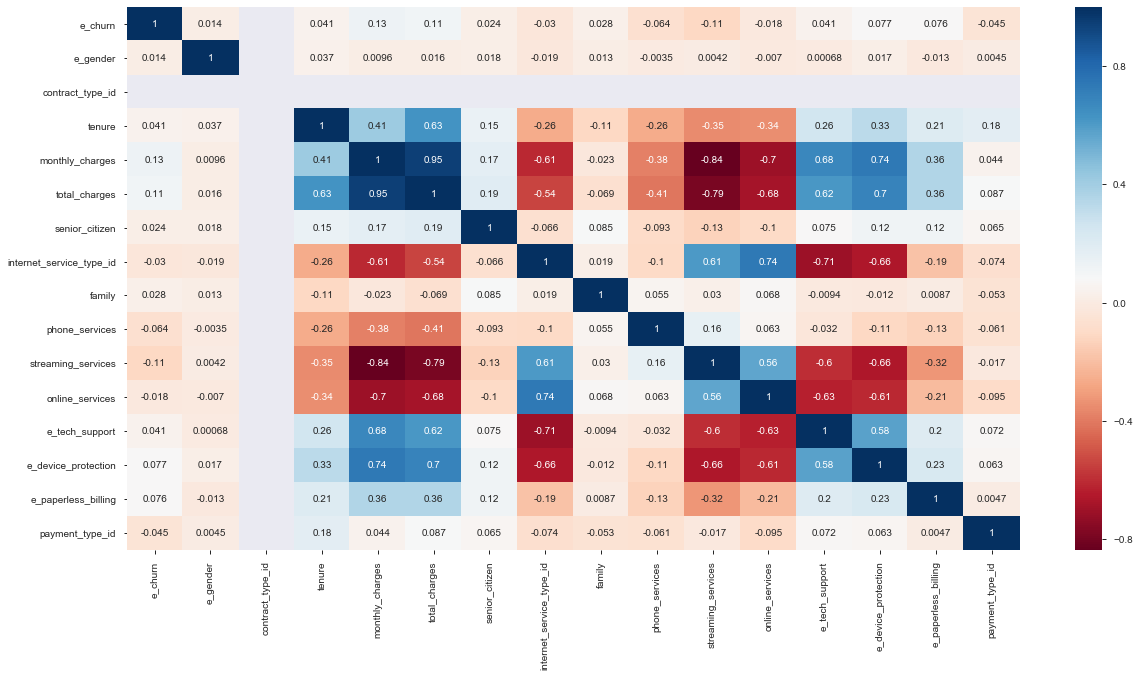

In [111]:
plt.figure(figsize=(20,10))
sns.heatmap(twoyear.corr(), annot = True, cmap ='RdBu')


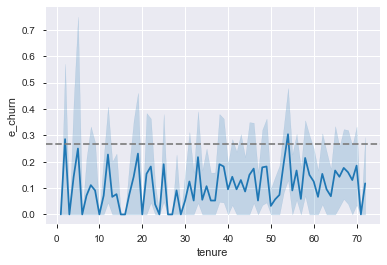

In [108]:
sns.lineplot(x="tenure", y="e_churn", data=oneyear)
plt.axhline(churn_rate, ls='--', color='grey')
plt.show()

## Month to Month Exploration

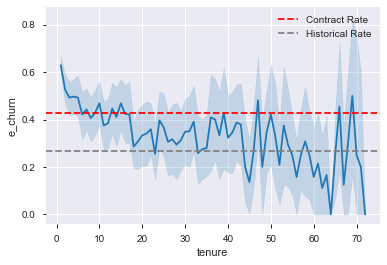

In [432]:
mtmchurn_rate = monthtomonth['e_churn'].mean()
sns.lineplot(x="tenure", y="e_churn", data=monthtomonth)

plt.axhline(mtmchurn_rate, label='Contract Rate', ls='--', color = 'red')
plt.axhline(churn_rate, label='Historical Rate', ls='--', color='grey')
plt.legend()
plt.show()

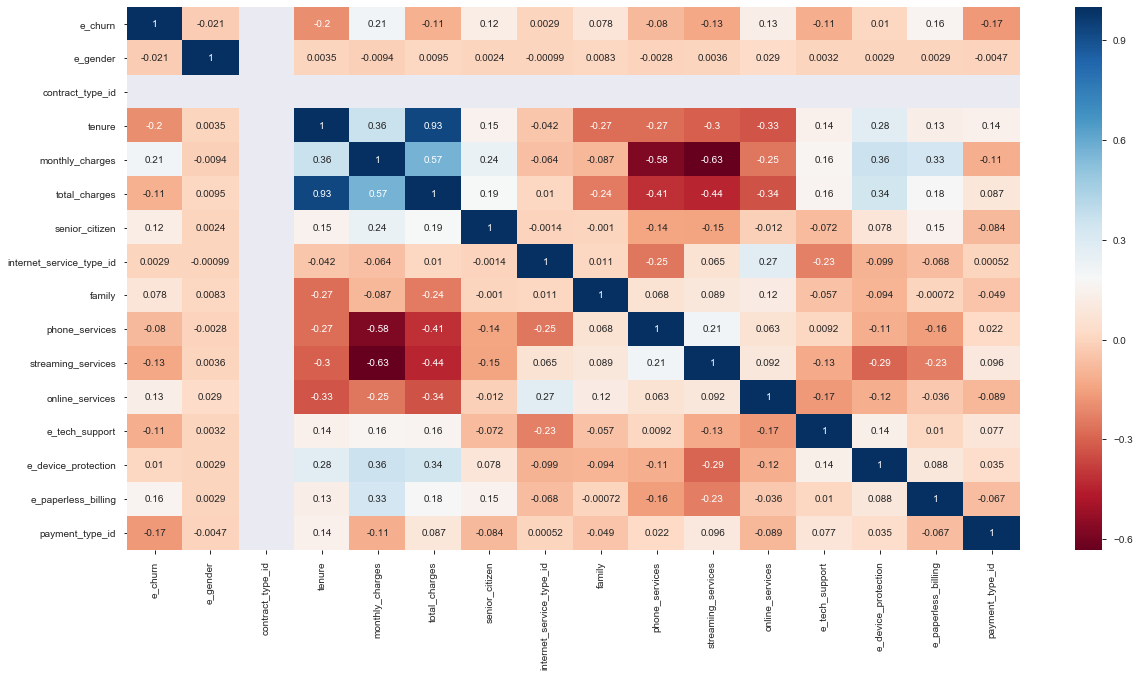

In [112]:
plt.figure(figsize=(20,10))
sns.heatmap(monthtomonth.corr(), annot = True, cmap ='RdBu')

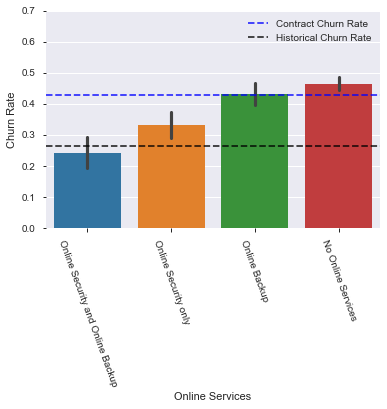

In [430]:
fig = sns.barplot(x="online_services", y='e_churn', data=monthtomonth)
fig.set_xticklabels(["Online Security and Online Backup", "Online Security only","Online Backup", 'No Online Services'])
fig.set(ylabel='Churn Rate')
plt.ylim(0, .7)
fig.set(xlabel='Online Services')
plt.axhline(mtmchurn_rate,alpha =.8, label="Contract Churn Rate", ls='--', color = 'blue')
plt.axhline(churn_rate, alpha = .8, label='Historical Churn Rate', ls='--', color='black')
plt.xticks(rotation=-70)
plt.legend()
plt.show()

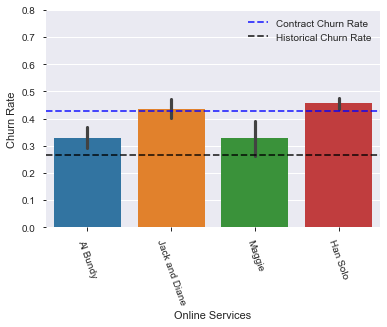

In [431]:
fig = sns.barplot(x="family", y='e_churn', data=monthtomonth)
fig.set_xticklabels(['Al Bundy', "Jack and Diane","Maggie", "Han Solo"])
fig.set(ylabel='Churn Rate')
plt.ylim(0, .8)
fig.set(xlabel='Online Services')
plt.axhline(mtmchurn_rate,alpha =.8, label="Contract Churn Rate", ls='--', color = 'blue')
plt.axhline(churn_rate, alpha = .8, label='Historical Churn Rate', ls='--', color='black')
plt.xticks(rotation=-70)
plt.legend()
plt.show()

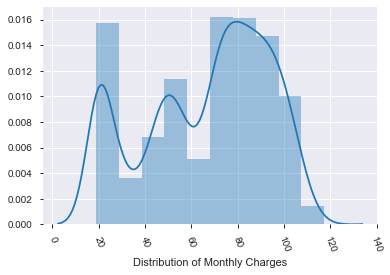

In [425]:
fig = sns.distplot(monthtomonth["monthly_charges"], bins = 10)
# fig.set_xticklabels([])
# plt.ylabel('Churn Rate')
fig.set(xlabel='Distribution of Monthly Charges')
# plt.axhline(mtmchurn_rate,alpha =.8, label="Contract Rate", ls='--', color = 'blue')
# plt.axhline(churn_rate, alpha = .8, label='Historical Rate', ls='--', color='black')
plt.xticks(rotation=-70)
# plt.legend()
plt.show()

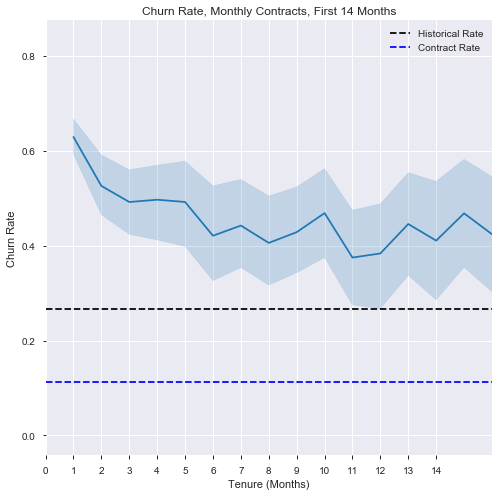

In [424]:
plt.figure(figsize=(8,8))
mtm_rate = monthtomonth['e_churn'].mean()
ax = sns.lineplot(x="tenure", y="e_churn", data=monthtomonth)
plt.xlim(0,16)
plt.xticks(np.arange(0, 15, step=1))
ax.set(xlabel='Tenure (Months)', ylabel = 'Churn Rate', title = 'Churn Rate, Monthly Contracts, First 14 Months')
plt.axhline(churn_rate, label='Historical Rate', ls='--', color='black')
plt.axhline(oneyear_rate, label = 'Contract Rate', ls='--', color='blue')
plt.legend()
plt.show()

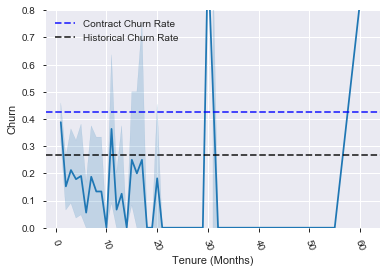

In [423]:
fig = sns.lineplot(x='tenure', y='e_churn', data=cheapmtm)
# fig.set_xticklabels(['No', 'Yes'])
fig.set(ylabel='Churn')
plt.ylim(0, .8)
fig.set(xlabel='Tenure (Months)')
plt.axhline(mtmchurn_rate,alpha =.8, label="Contract Churn Rate", ls='--', color = 'blue')
plt.axhline(churn_rate, alpha = .8, label='Historical Churn Rate', ls='--', color='black')
plt.xticks(rotation=-70)
plt.legend()
plt.show()

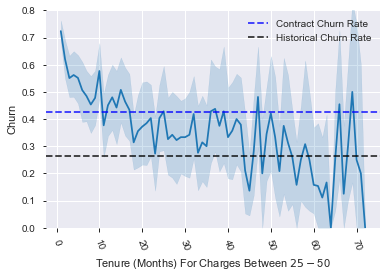

In [422]:
fig = sns.lineplot(x='tenure', y='e_churn', data=midtiermtm)
# fig.set_xticklabels(['No', 'Yes'])
fig.set(ylabel='Churn')
plt.ylim(0, .8)
fig.set(xlabel='Tenure (Months) For Charges Between $25 -$50')
plt.axhline(mtmchurn_rate,alpha =.8, label="Contract Churn Rate", ls='--', color = 'blue')
plt.axhline(churn_rate, alpha = .8, label='Historical Churn Rate', ls='--', color='black')
plt.xticks(rotation=-70)
plt.legend()
plt.show()

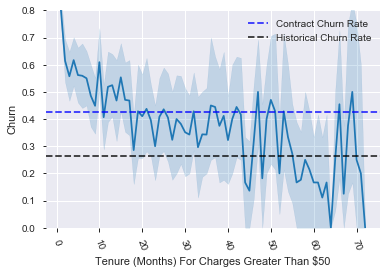

In [420]:
fig = sns.lineplot(x='tenure', y='e_churn', data=priceymtm)
# fig.set_xticklabels(['No', 'Yes'])
fig.set(ylabel='Churn')
plt.ylim(0, .8)
fig.set(xlabel='Tenure (Months) For Charges Greater Than $50')
plt.axhline(mtmchurn_rate,alpha =.8, label="Contract Churn Rate", ls='--', color = 'blue')
plt.axhline(churn_rate, alpha = .8, label='Historical Churn Rate', ls='--', color='black')
plt.xticks(rotation=-70)
plt.legend()
plt.show()

# Month to month has a higher historical churn rate than other contracts

# 1 Year Exploration

In [177]:
oneyear = encoded_df[encoded_df['contract_type_id'] == 2]

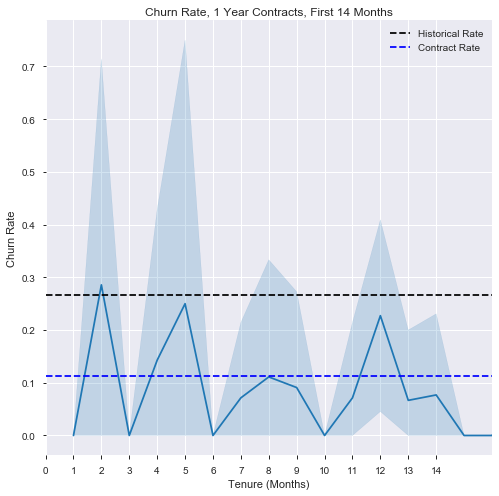

In [419]:
plt.figure(figsize=(8,8))
oneyear_rate = oneyear['e_churn'].mean()
ax = sns.lineplot(x="tenure", y="e_churn", data=oneyear)
plt.xlim(0,16)
plt.xticks(np.arange(0, 15, step=1))
ax.set(xlabel='Tenure (Months)', ylabel = 'Churn Rate', title = 'Churn Rate, 1 Year Contracts, First 14 Months')
plt.axhline(churn_rate, label='Historical Rate', ls='--', color='black')
plt.axhline(oneyear_rate, label = 'Contract Rate', ls='--', color='blue')
plt.legend()
plt.show()

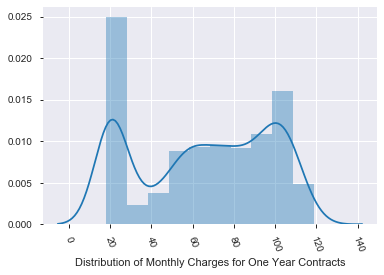

In [418]:
fig = sns.distplot(oneyear["monthly_charges"], bins = 10)
# fig.set_xticklabels([])
# plt.ylabel('Churn Rate')
fig.set(xlabel='Distribution of Monthly Charges for One Year Contracts')
# plt.axhline(mtmchurn_rate,alpha =.8, label="Contract Rate", ls='--', color = 'blue')
# plt.axhline(churn_rate, alpha = .8, label='Historical Rate', ls='--', color='black')
plt.xticks(rotation=-70)
# plt.legend()
plt.show()

In [182]:
## Creating different tiers for the one year contracts

monthtomonth = encoded_df[encoded_df['contract_type_id'] == 1]
oneyear = encoded_df[encoded_df['contract_type_id'] == 2]
twoyear = encoded_df[encoded_df['contract_type_id'] == 3]
pricey1year = oneyear[oneyear['monthly_charges'] >=100]
midtier1year= oneyear[oneyear['monthly_charges'] < 100]
midtier1year= oneyear[oneyear['monthly_charges'] >=40]
cheap1year = oneyear[oneyear['monthly_charges'] <40]

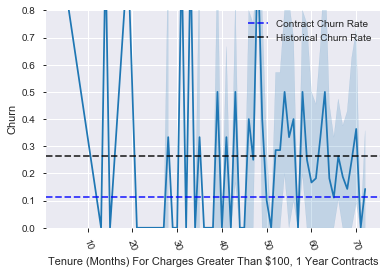

In [417]:
fig = sns.lineplot(x='tenure', y='e_churn', data=pricey1year)
# fig.set_xticklabels(['No', 'Yes'])
fig.set(ylabel='Churn')
plt.ylim(0, .8)
fig.set(xlabel='Tenure (Months) For Charges Greater Than $100, 1 Year Contracts')
plt.axhline(oneyear_rate,alpha =.8, label="Contract Churn Rate", ls='--', color = 'blue')
plt.axhline(churn_rate, alpha = .8, label='Historical Churn Rate', ls='--', color='black')
plt.xticks(rotation=-70)
plt.legend()
plt.show()

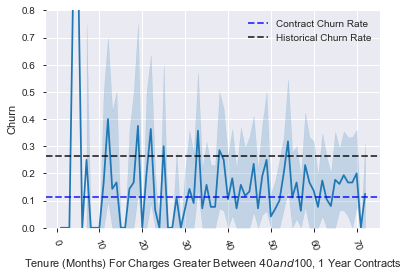

In [416]:
fig = sns.lineplot(x='tenure', y='e_churn', data=midtier1year)
fig.set(ylabel='Churn')
plt.ylim(0, .8)
fig.set(xlabel='Tenure (Months) For Charges Greater Between $40 and $100, 1 Year Contracts')
plt.axhline(oneyear_rate,alpha =.8, label="Contract Churn Rate", ls='--', color = 'blue')
plt.axhline(churn_rate, alpha = .8, label='Historical Churn Rate', ls='--', color='black')
plt.xticks(rotation=-70)
plt.legend()
plt.show()

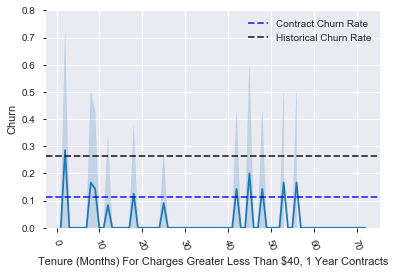

In [415]:
fig = sns.lineplot(x='tenure', y='e_churn', data=cheap1year)
fig.set(ylabel='Churn')
plt.ylim(0, .8)
fig.set(xlabel='Tenure (Months) For Charges Greater Less Than $40, 1 Year Contracts')
plt.axhline(oneyear_rate,alpha =.8, label="Contract Churn Rate", ls='--', color = 'blue')
plt.axhline(churn_rate, alpha = .8, label='Historical Churn Rate', ls='--', color='black')
plt.xticks(rotation=-70)
plt.legend()
plt.show()

# Conclusion:

## There is high volatility with high priced 1 year contracts that decreases as the monthly charges decreases

# Two Year Contracts

In [187]:
twoyear = encoded_df[encoded_df['contract_type_id'] == 3]

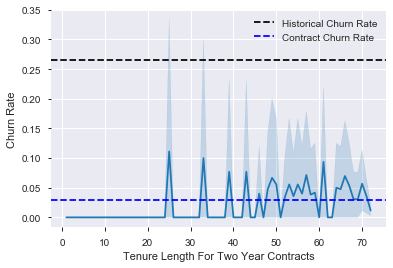

In [414]:
twoyear_rate = twoyear['e_churn'].mean()

ax2 = sns.lineplot(x="tenure", y="e_churn", data=twoyear)
ax2.set(xlabel='Tenure Length For Two Year Contracts', ylabel = 'Churn Rate')
# plt.ylabel('Churn Rate')
plt.axhline(churn_rate, label='Historical Churn Rate', ls='--', color='black')
plt.axhline(twoyear_rate, label = 'Contract Churn Rate', ls='--', color='blue')
plt.legend()
plt.show()

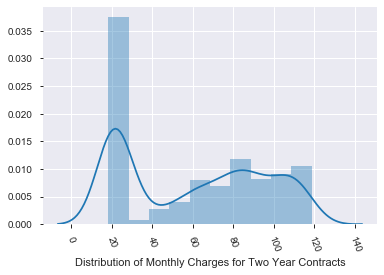

In [413]:
fig = sns.distplot(twoyear["monthly_charges"], bins = 10)
# fig.set_xticklabels([])
# plt.ylabel('Churn Rate')
fig.set(xlabel='Distribution of Monthly Charges for Two Year Contracts')
# plt.axhline(mtmchurn_rate,alpha =.8, label="Contract Rate", ls='--', color = 'blue')
# plt.axhline(churn_rate, alpha = .8, label='Historical Rate', ls='--', color='black')
plt.xticks(rotation=-70)
# plt.legend()
plt.show()

In [191]:
monthtomonth = encoded_df[encoded_df['contract_type_id'] == 1]
oneyear = encoded_df[encoded_df['contract_type_id'] == 2]
twoyear = encoded_df[encoded_df['contract_type_id'] == 3]
pricey2year = twoyear[twoyear['monthly_charges'] >=100]
midtier2year= twoyear[twoyear['monthly_charges'] < 100]
midtier2year= twoyear[twoyear['monthly_charges'] >=40]
cheap2year = twoyear[twoyear['monthly_charges'] <40]

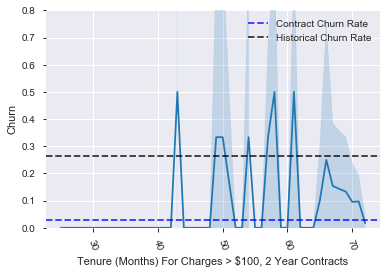

In [410]:
fig = sns.lineplot(x='tenure', y='e_churn', data=pricey2year)
# fig.set_xticklabels(['No', 'Yes'])
fig.set(ylabel='Churn')
plt.ylim(0, .8)
fig.set(xlabel='Tenure (Months) For Charges > $100, 2 Year Contracts')
plt.axhline(twoyear_rate,alpha =.8, label="Contract Churn Rate", ls='--', color = 'blue')
plt.axhline(churn_rate, alpha = .8, label='Historical Churn Rate', ls='--', color='black')
plt.xticks(rotation=-70)
plt.legend()
plt.show()

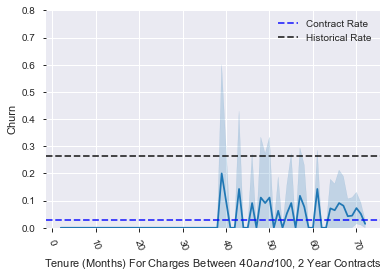

In [411]:
fig = sns.lineplot(x='tenure', y='e_churn', data=midtier2year)
fig.set(ylabel='Churn')
plt.ylim(0, .8)
fig.set(xlabel='Tenure (Months) For Charges Between $40 and $100, 2 Year Contracts')
plt.axhline(twoyear_rate,alpha =.8, label="Contract Rate", ls='--', color = 'blue')
plt.axhline(churn_rate, alpha = .8, label='Historical Rate', ls='--', color='black')
plt.xticks(rotation=-70)
plt.legend()
plt.show()

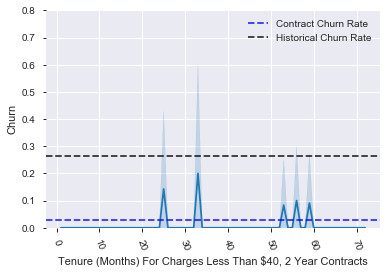

In [412]:
fig = sns.lineplot(x='tenure', y='e_churn', data=cheap2year)
fig.set(ylabel='Churn')
plt.ylim(0, .8)
fig.set(xlabel='Tenure (Months) For Charges Less Than $40, 2 Year Contracts')
plt.axhline(twoyear_rate,alpha =.8, label="Contract Churn Rate", ls='--', color = 'blue')
plt.axhline(churn_rate, alpha = .8, label='Historical Churn Rate', ls='--', color='black')
plt.xticks(rotation=-70)
plt.legend()
plt.show()

# Conclusion: There is less volatility for a greater period of time. Churn rates are higher with more expensive two year contracts.

In [208]:
original_df = df.drop(columns= ['e_gender','family', 'phone_services',
       'streaming_services', 'online_services', 'e_tech_support',
       'e_device_protection', 'e_paperless_billing', 'e_churn'])
original_df.head()

,customer_id,churn,contract_type_id,contract_type,tenure,monthly_charges,total_charges,gender,partner,dependents,...,internet_service_type_id,tech_support,streaming_tv,streaming_movies,online_security,online_backup,device_protection,payment_type,payment_type_id,paperless_billing
0,0003-MKNFE,No,1,Month-to-month,9,59.9,542.40,Male,No,No,...,1,No,No,Yes,No,No,No,Mailed check,2,No
1,0013-MHZWF,No,1,Month-to-month,9,69.4,571.45,Female,No,Yes,...,1,Yes,Yes,Yes,No,No,No,Credit card (automatic),4,Yes
2,0015-UOCOJ,No,1,Month-to-month,7,48.2,340.35,Female,No,No,...,1,No,No,No,Yes,No,No,Electronic check,1,Yes
3,0023-HGHWL,Yes,1,Month-to-month,1,25.1,25.10,Male,No,No,...,1,No,No,No,No,No,No,Electronic check,1,Yes
4,0032-PGELS,Yes,1,Month-to-month,1,30.5,30.50,Female,Yes,Yes,...,1,No,No,No,Yes,No,No,Bank transfer (automatic),3,No


# Explore
Could the month in which they signed up influence churn? i.e. if a cohort is identified by tenure, is there a cohort or cohorts who have a higher rate of churn than other cohorts? (Plot the rate of churn on a line chart where x is the tenure and y is the rate of churn (customers churned/total customers)).

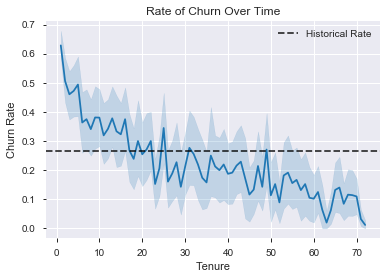

In [225]:
ax = sns.lineplot(x="tenure", y="e_churn", data=train)
ax.set(xlabel= 'Tenure', ylabel ='Churn Rate', title= 'Rate of Churn Over Time')
# plt.xlabel("Tenure Length")
# # plt.ylabel('Churn Rate')
plt.axhline(churn_rate, alpha = .8, label='Historical Rate', ls='--', color='black')
plt.legend()
plt.show()

__One cannot determine whether signing up on a particular month causes churn. Overall churn rate decreases over time.__

# Are there features that indicate a higher propensity to churn? like type of internet service, type of phone service, online security and backup, senior citizens, paying more than x% of customers with the same services, etc.?

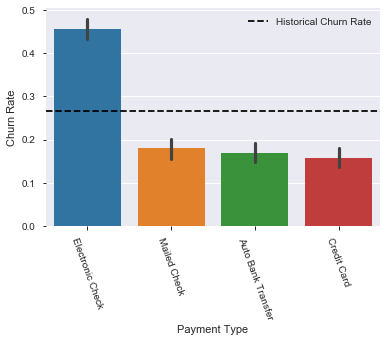

In [237]:
fig = sns.barplot(x="payment_type_id", y="e_churn", data=train)
fig.set_xticklabels(["Electronic Check", "Mailed Check","Auto Bank Transfer", "Credit Card"])
fig.set(ylabel = 'Churn Rate', xlabel = 'Payment Type')
# plt.xlabel('Payment Type')
plt.axhline(churn_rate, label = 'Historical Churn Rate', ls='--', color='black')
plt.xticks(rotation=-70)
plt.legend()
plt.show()

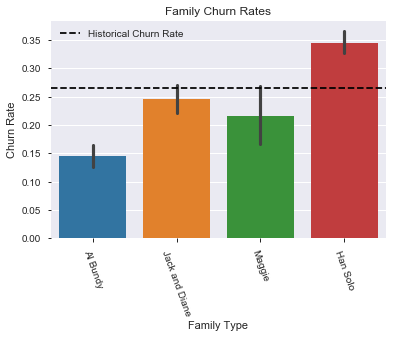

In [236]:
fig = sns.barplot(x="family", y="e_churn", data=train)
fig.set_xticklabels(['Al Bundy', "Jack and Diane","Maggie", "Han Solo"])
fig.set(ylabel = 'Churn Rate', xlabel = 'Family Type', title = 'Family Churn Rates')
plt.axhline(churn_rate, label = 'Historical Churn Rate', ls='--', color='black')
plt.xticks(rotation=-70)
plt.legend()
plt.show()

In [239]:
train.columns

Index(['customer_id', 'e_churn', 'e_gender', 'contract_type_id',
       'contract_type', 'tenure', 'monthly_charges', 'total_charges',
       'senior_citizen', 'internet_service_type_id', 'family',
       'phone_services', 'streaming_services', 'online_services',
       'e_tech_support', 'e_device_protection', 'e_paperless_billing',
       'payment_type_id'],
      dtype='object')

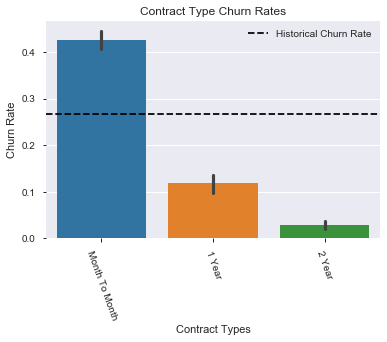

In [238]:
fig = sns.barplot(x="contract_type_id", y="e_churn", data=train)
fig.set_xticklabels(['Month To Month', "1 Year","2 Year"])
fig.set(ylabel = 'Churn Rate', xlabel = 'Contract Types', title = 'Contract Type Churn Rates')
plt.axhline(churn_rate, label = 'Historical Churn Rate', ls='--', color='black')
plt.xticks(rotation=-70)
plt.legend()
plt.show()

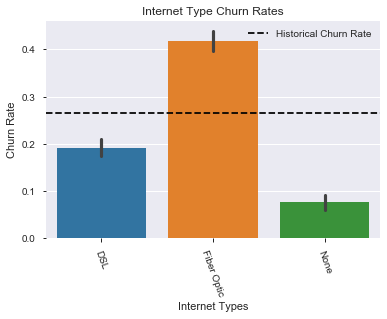

In [240]:
fig = sns.barplot(x="internet_service_type_id", y="e_churn", data=train)
fig.set_xticklabels(['DSL', "Fiber Optic","None"])
fig.set(ylabel = 'Churn Rate', xlabel = 'Internet Types', title = 'Internet Type Churn Rates')
plt.axhline(churn_rate, label = 'Historical Churn Rate', ls='--', color='black')
plt.xticks(rotation=-70)
plt.legend()
plt.show()

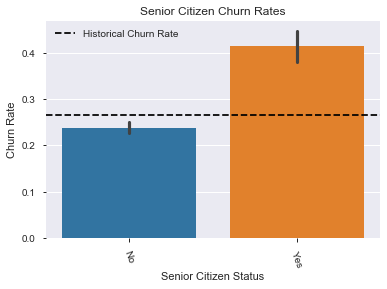

In [241]:
fig = sns.barplot(x="senior_citizen", y="e_churn", data=train)
fig.set_xticklabels(['No', "Yes"])
fig.set(ylabel = 'Churn Rate', xlabel = 'Senior Citizen Status', title = 'Senior Citizen Churn Rates')
plt.axhline(churn_rate, label = 'Historical Churn Rate', ls='--', color='black')
plt.xticks(rotation=-70)
plt.legend()
plt.show()

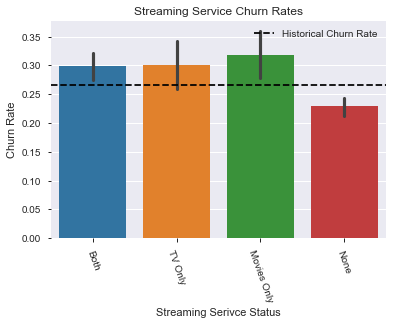

In [243]:
fig = sns.barplot(x="streaming_services", y="e_churn", data=train)
fig.set_xticklabels(['Both', "TV Only", "Movies Only", "None"])
fig.set(ylabel = 'Churn Rate', xlabel = 'Streaming Serivce Status', title = 'Streaming Service Churn Rates')
plt.axhline(churn_rate, label = 'Historical Churn Rate', ls='--', color='black')
plt.xticks(rotation=-70)
plt.legend()
plt.show()

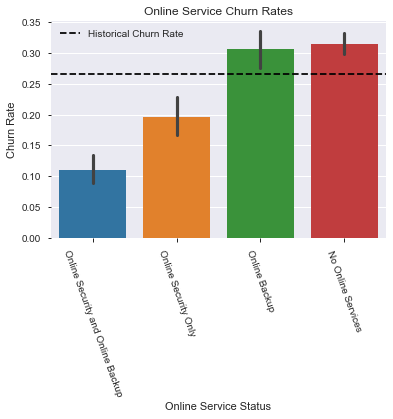

In [245]:
fig = sns.barplot(x="online_services", y="e_churn", data=train)
fig.set_xticklabels(['Online Security and Online Backup', "Online Security Only", "Online Backup", "No Online Services"])
fig.set(ylabel = 'Churn Rate', xlabel = 'Online Service Status', title = 'Online Service Churn Rates')
plt.axhline(churn_rate, label = 'Historical Churn Rate', ls='--', color='black')
plt.xticks(rotation=-70)
plt.legend()
plt.show()

# Conclusion:

## There appears to be some notable features that churn above the higher than historical churn rate. They include customers:

- Who pay by electronic check
- Single people
- Are on month to month contracts
- Who have fiber optics internet services
- Are senior citizens
- Participate in streaming services
- Have little to no participation in online services
- Enjoy paperless billing

# Is there a price threshold for specific services where the likelihood of churn increases once price for those services goes past that point? If so, what is that point for what service(s)?


__The clarity of this question is not enough to form a well intentioned search of the data. Furthermore, the structure of the data does not provide the explorer the opportunity to pinpoint the cost of each service, let alone hashout the specifics of each customer's monthly and annual charges and where the tipping point for churning occurs. It is irresponsible to display graphs that are known to be erroneous or misleading, ergo, they will not be furnished.__


# If we looked at churn rate for month-to-month customers after the 12th month and that of 1-year contract customers after the 12th month, are those rates comparable?

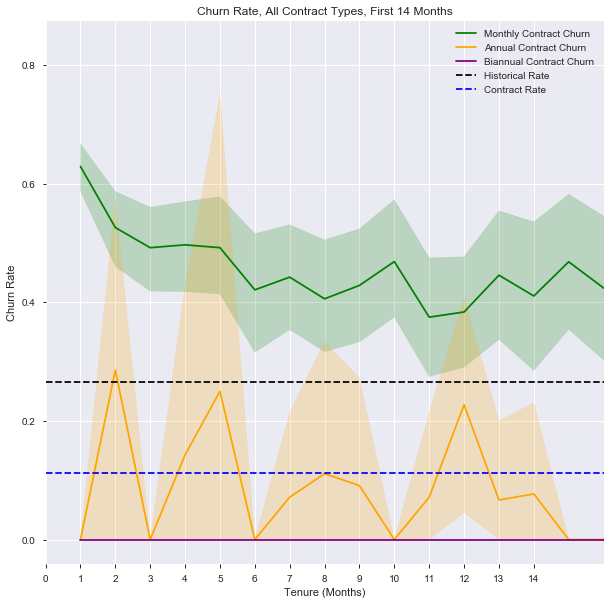

In [404]:
plt.figure(figsize=(10,10))
mtm_rate = monthtomonth['e_churn'].mean()
ax = sns.lineplot(x="tenure", y="e_churn", data=monthtomonth, label = 'Monthly Contract Churn', color = 'green')
ax1 = sns.lineplot(x="tenure", y="e_churn", data=oneyear, label ='Annual Contract Churn', color = 'orange')
ax2 = sns.lineplot(x="tenure", y="e_churn", data=twoyear, label ='Biannual Contract Churn', color= 'purple')
plt.xlim(0,16)
plt.xticks(np.arange(0, 15, step=1))
ax.set(xlabel='Tenure (Months)', ylabel = 'Churn Rate', title = 'Churn Rate, All Contract Types, First 14 Months')
plt.axhline(churn_rate, label='Historical Rate', ls='--', color='black')
plt.axhline(oneyear_rate, label = 'Contract Rate', ls='--', color='blue')
plt.legend()
plt.show()


# Controlling for services (phone_id, internet_service_type_id, online_security_backup, device_protection, tech_support, and contract_type_id), is the mean monthly_charges of those who have churned significantly different from that of those who have not churned? (Use a t-test to answer this.)

- H0: There is no difference in monthly charges between customers who have churned and those who have not.
- H1: There is a difference in monthly charges between those who have churned and those who have not.

In [301]:
Q5df= train[['contract_type_id','e_churn','e_device_protection','e_paperless_billing','e_tech_support','internet_service_type_id','online_services', 'payment_type_id',
       'phone_services', 'monthly_charges']]
Q5df[Q5df.e_churn==0].monthly_charges.mean()
Q5df[Q5df.e_churn==1].monthly_charges.mean()

stats.ttest_ind(Q5df[Q5df.e_churn==1].monthly_charges, Q5df[Q5df.e_churn==0].monthly_charges)

Ttest_indResult(statistic=13.593352346299858, pvalue=2.427164671765997e-41)

__We reject the null hypothesis. There appears to be a difference__

# How much of monthly_charges can be explained by internet_service_type? (hint: correlation test). State your hypotheses and your conclusion clearly.

__H0: There is no relationship between monthly_charges and internet_service_type__
__H1: There is a relationship between monthly_charges and internet_service_type__


In [318]:
print(stats.pearsonr(train['monthly_charges'], train['internet_service_type_id'].map({3:0, 1:2, 2:1})))


(0.3224631165604208, 1.759196213268457e-119)


## Conclusion:

__There is a significant relationship between monthly_charges and internet_service type.__
__We reject the null hypothesis. The correlation between the two identifiers is negative and minor__

# How much of monthly_charges can be explained by internet_service_type + phone service type (0, 1, or multiple lines). State your hypotheses and your conclusion clearly.

__H0: There is no relationship between monthly_charges and the combo of the other two__
__H1: There is a relationship__



In [324]:
import math
rxz = stats.pearsonr(train['internet_service_type_id'].map({3:0, 1:2, 2:1}), train['monthly_charges'])[0]
ryz = stats.pearsonr(train['phone_services'].map({2:0, 1:1, 0:2}), train['monthly_charges'])[0]
rxy = stats.pearsonr(train['internet_service_type_id'].map({3:0, 1:2, 2:1}), train['phone_services'].map({2:0, 1:1, 0:2}))[0]
math.sqrt((rxz**2 + ryz**2 - 2*rxz*rxy*ryz)/(1 - rxy**2))



0.6475109018272879

## Seems like just over half of the monthly charges can be explained by the choice of internet and phone service. It is intuitive to a point. 

# Create visualizations exploring the interactions of variables (independent with independent and independent with dependent). The goal is to identify features that are related to churn, identify any data integrity issues, understand 'how the data works'. For example, we may find that all who have online services also have device protection. In that case, we don't need both of those. (The visualizations done in your analysis for questions 1-5 count towards the requirements below)

In [434]:
original_df.columns

Index(['customer_id', 'churn', 'contract_type_id', 'contract_type', 'tenure',
       'monthly_charges', 'total_charges', 'gender', 'partner', 'dependents',
       'senior_citizen', 'phone_service', 'multiple_lines',
       'internet_service_type', 'internet_service_type_id', 'tech_support',
       'streaming_tv', 'streaming_movies', 'online_security', 'online_backup',
       'device_protection', 'payment_type', 'payment_type_id',
       'paperless_billing'],
      dtype='object')

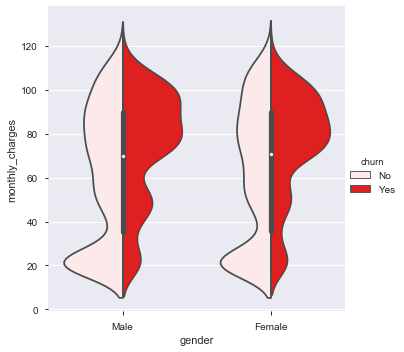

In [368]:
sns.catplot(x="gender", y="monthly_charges", hue="churn", kind="violin", split=True, color = "red", data=original_df);

__People with higher rates tend to leave, regardless of sex__

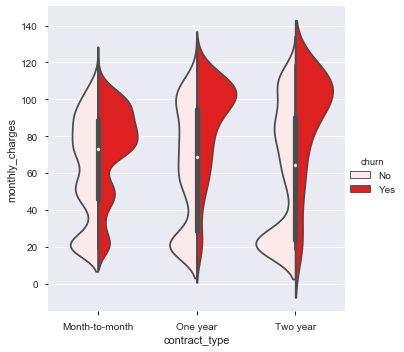

In [435]:
sns.catplot(x="contract_type", y="monthly_charges", hue="churn", kind="violin", split=True, color = "red", data=original_df)

__Customers with higher rates tend to churn, regardless of contract type__

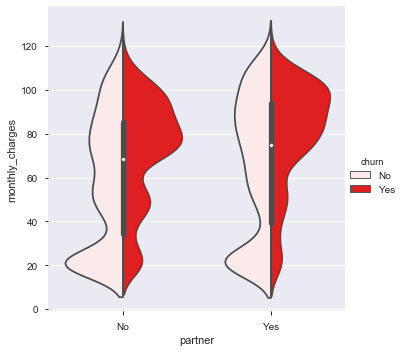

In [436]:
sns.catplot(x="partner", y="monthly_charges", hue="churn", kind="violin", split=True, color = "red", data=original_df)

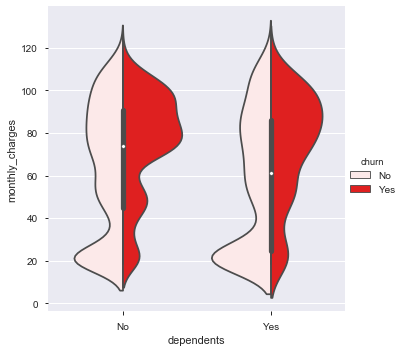

In [437]:
sns.catplot(x="dependents", y="monthly_charges", hue="churn", kind="violin", split=True, color = "red", data=original_df)

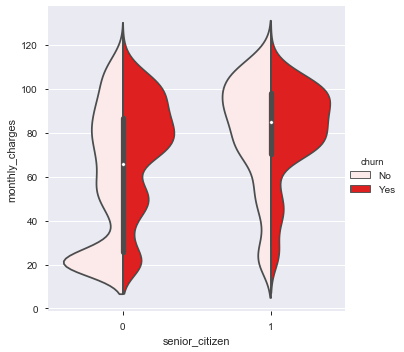

In [438]:
sns.catplot(x="senior_citizen", y="monthly_charges", hue="churn", kind="violin", split=True, color = "red", data=original_df)

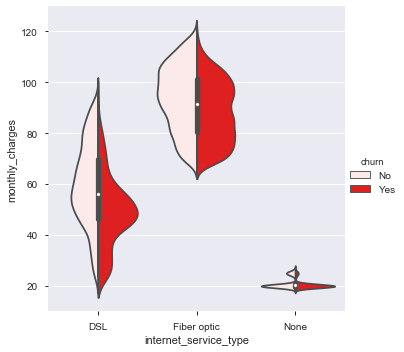

In [439]:
sns.catplot(x="internet_service_type", y="monthly_charges", hue="churn", kind="violin", split=True, color = "red", data=original_df)

# Conclusions General

The variables with the highest correlation to whether a customer churns or not are monthly charges, total charges, and tenure. I elected to not scale this data before I compared it to the target variable, which was predicting where someone churned or not. After examining all of the models that I was familiar with, I concluded that using a simple Decision Tree model with a depth of 2 created a predictability score of around .8. I feel satisfied with this score because it does not overfit the data. I fear that increasing the number of features might cause the curse of dimensionality with too few data points being available for training and testing. However, there exists future research with models that fit other classifications, such as family type, type of contract, etc.

There are a number of features with subsets that churn at a greater than average rate compared to the historical average. This poses a number of questions that warrant further research. Such features include things like family types and the different types of contracts. Preliminary exloration suggest that perhaps the better classification model layer might be found not with just the numeric features, but in the subsets of a different classifier such as contract types. 